<a href="https://colab.research.google.com/github/hoanglam372000/Applied-Data-Science-Group-7/blob/alyhakim/BaseLine_NaiveBayes_trucquan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/hoanglam372000/Applied-Data-Science-Group-7.git

fatal: destination path 'Applied-Data-Science-Group-7' already exists and is not an empty directory.


In [ ]:
!pip install contractions
!pip install emoji
!pip install autocorrect

In [ ]:
import pandas as pd
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('wordnet')
import numpy as np
import emoji
import re
import string
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
import matplotlib.pyplot as plt
#import contractions
from nltk.corpus import wordnet
from nltk.stem import PorterStemmer, WordNetLemmatizer
from bs4 import BeautifulSoup
from autocorrect import Speller
nltk.download('names')
names = nltk.corpus.names.words('male.txt') + nltk.corpus.names.words('female.txt')
pd.set_option('display.max_colwidth', 200)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package names to /root/nltk_data...
[nltk_data]   Package names is already up-to-date!


In [ ]:
df = pd.read_csv('/content/Applied-Data-Science-Group-7/train.csv')

In [ ]:
df

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on the releases we already bought","Sons of ****,",negative
...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband lost his job and can`t afford it,d lost,negative
27477,4f4c4fc327,"I`ve wondered about rake to. The client has made it clear .NET only, don`t force devs to learn a new lang #agile #ccnet",", don`t force",negative
27478,f67aae2310,Yay good for both of you. Enjoy the break - you probably need it after such hectic weekend Take care hun xxxx,Yay good for both of you.,positive
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [ ]:
df.dropna(inplace= True)

In [ ]:
data = df
data

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on the releases we already bought","Sons of ****,",negative
...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband lost his job and can`t afford it,d lost,negative
27477,4f4c4fc327,"I`ve wondered about rake to. The client has made it clear .NET only, don`t force devs to learn a new lang #agile #ccnet",", don`t force",negative
27478,f67aae2310,Yay good for both of you. Enjoy the break - you probably need it after such hectic weekend Take care hun xxxx,Yay good for both of you.,positive
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive


# Thống kê

In [ ]:
def preprocessing(tweet):
    '''
    input: a tweet (str)
    output: a list of words (list)
    '''
    tweet = str(tweet).strip()
    new_tweet = tweet.split()
    index2word = { w:new_tweet[w] for w in range(len(new_tweet))}
    #word2index = { new_tweet[w]:w for w in range(len(new_tweet))} # Biễu diễn mỗi từ là 1 index để sau này phục hồi
    #print('origin: ',word2index)
    preprocess_tweet = dict({i[0]:i[1].lower()  for i in index2word.items()})
    #preprocess_tweet = {re.sub(r'i[`\'"][\w]+', 'i',w[0]):w[1] for w in preprocess_tweet.items()}
    preprocess_tweet = {w[0]:re.sub(r'https?:\/\/.*[\r\n]*', '<URL>',w[1]) for w in preprocess_tweet.items()}
    preprocess_tweet = {w[0]:re.sub(r'\*+', '<HIDDEN>',w[1]) for w in preprocess_tweet.items()}
    preprocess_tweet = {w[0]:re.sub(r'@\w+', '<tag>',w[1]) for w in preprocess_tweet.items()}
    preprocess_tweet = {w[0]:re.sub(r'@\w+', '<tag>',w[1]) for w in preprocess_tweet.items()}
    preprocessed_tweet = {}
    for w in preprocess_tweet.items():
      if emoji.get_emoji_regexp().search(w[1]) or w[1].isalpha() or w[1]=='<URL>':
        preprocessed_tweet[w[0]] = w[1]
      elif w[1].isdigit():
        preprocessed_tweet[w[0]] = w[1].replace(w[1],'<NUMBER>')
      
      else:
        
          r = re.sub(r"[#!\"$%&\'*+,-\.?@\[\]`{|}]*",'',w[1])
          preprocessed_tweet[w[0]] = r
    stemmer = PorterStemmer()
    preprocessed_tweet = {w[0]:stemmer.stem(w[1]) for w in preprocessed_tweet.items()}
    return index2word,preprocessed_tweet

In [ ]:
def preprocess_tweets(X_df):
  X_df = X_df.copy()
  raw_tweets = X_df.text.to_list()
  X_df.sentiment = X_df.sentiment.map({'negative':-1,'neutral':0,'positive':1}).to_list()
  index2word_tweets = [] #list of dictionaries
  preprocessed_tweets = [] #list of dictionaries
  for tweet in raw_tweets:
    index2word, preprocessed = preprocessing(tweet)
    index2word_tweets.append(index2word)
    preprocessed_tweets.append(preprocessed)
  
  preprocessed_X_df = pd.DataFrame(data={'textID':X_df.textID,'index2word':index2word_tweets, 'preprocessed_texts':preprocessed_tweets,'sentiment':X_df.sentiment})
  return preprocessed_X_df

In [ ]:
pre_data = preprocess_tweets(data)
pre_data.head()

,textID,index2word,preprocessed_texts,sentiment
0,cb774db0d1,"{0: 'I`d', 1: 'have', 2: 'responded,', 3: 'if', 4: 'I', 5: 'were', 6: 'going'}","{0: 'id', 1: 'have', 2: 'respond', 3: 'if', 4: 'i', 5: 'were', 6: 'go'}",0
1,549e992a42,"{0: 'Sooo', 1: 'SAD', 2: 'I', 3: 'will', 4: 'miss', 5: 'you', 6: 'here', 7: 'in', 8: 'San', 9: 'Diego!!!'}","{0: 'sooo', 1: 'sad', 2: 'i', 3: 'will', 4: 'miss', 5: 'you', 6: 'here', 7: 'in', 8: 'san', 9: 'diego'}",-1
2,088c60f138,"{0: 'my', 1: 'boss', 2: 'is', 3: 'bullying', 4: 'me...'}","{0: 'my', 1: 'boss', 2: 'is', 3: 'bulli', 4: 'me'}",-1
3,9642c003ef,"{0: 'what', 1: 'interview!', 2: 'leave', 3: 'me', 4: 'alone'}","{0: 'what', 1: 'interview', 2: 'leav', 3: 'me', 4: 'alon'}",-1
4,358bd9e861,"{0: 'Sons', 1: 'of', 2: '****,', 3: 'why', 4: 'couldn`t', 5: 'they', 6: 'put', 7: 'them', 8: 'on', 9: 'the', 10: 'releases', 11: 'we', 12: 'already', 13: 'bought'}","{0: 'son', 1: 'of', 2: '<hidden>', 3: 'whi', 4: 'couldnt', 5: 'they', 6: 'put', 7: 'them', 8: 'on', 9: 'the', 10: 'releas', 11: 'we', 12: 'alreadi', 13: 'bought'}",-1


In [ ]:
#chia tập dữ liệu thành các tập neutral, positive, negative để thống kê
neutral_list = []
positive_list = []
negative_list = []
for i in range(len(pre_data)):
  if pre_data.iloc[i]['sentiment'] == 0:
    neutral_list.append(pre_data.iloc[i])
  elif pre_data.iloc[i]['sentiment'] == 1:
    negative_list.append(pre_data.iloc[i])
  elif pre_data.iloc[i]['sentiment'] == -1:
    positive_list.append(pre_data.iloc[i])
  else:
    continue

neutral_df = pd.DataFrame(neutral_list)
positive_df = pd.DataFrame(positive_list)
negative_df = pd.DataFrame(negative_list)

In [ ]:
# thống kê trên 1 tweet
from nltk.tokenize import RegexpTokenizer
def count_tweet(tweet):
  '''
  Input: tweet
  Output: độ dài câu, số lượng dấu câu, số lượng danh từ, tính từ, động từ
  '''
  #dict để lưu kết quả của từng tweet
  result = {
      'textID':None,
      #'punc':None,
      'token':None
  }
  
  result['textID'] = tweet['textID']

  #đếm dấu câu
  # count_punc = lambda l1, l2: len(list(filter(lambda c: c in l2, l1))) 
  # punc = count_punc(tweet['text'], string.punctuation)
  # result['punc'] = punc
  
  #đếm số lượng từ đơn
  result['token'] = len(tweet['preprocessed_texts'])
  # tokenizer = RegexpTokenizer(r'\w+')
  # tokens = tokenizer.tokenize(tweet['text'])
  # result['token'] = len(tokens)

  #đếm số lượng danh, động, tính từ trong 1 tweet
  tags = []
  for i in tweet['preprocessed_texts'].values():
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(i)
    token = set(tokens)
    _temp = nltk.pos_tag(token)
    for i in _temp:
      tags.append(i[1])
  # token = set(tokens)
  # temp = nltk.pos_tag(token)
  # tags = []
  # for i in temp:
  #   tags.append(i[1])
  count_noun = tags.count('NN') + tags.count('NNS') + tags.count('NNP') + tags.count('NNPS')
  count_verb = tags.count('VB') + tags.count('VBD') + tags.count('VBG') + tags.count('VBN') + tags.count('VBP') + tags.count('VBZ')
  count_adj = tags.count('JJR') + tags.count('JJ') + tags.count('JJS')

  result['noun'] = count_noun
  result['verb'] = count_verb
  result['adj'] = count_adj

  return result

In [ ]:
#thống kê trên ds tweet
def count_tweets(list_tweets):
  list_results = []
  for i in range(len(list_tweets)):
    tweet = count_tweet(list_tweets.iloc[i])
    list_results.append(tweet)
  return list_results

In [ ]:
static_list_tweet = count_tweets(pre_data)
static_neutral_tweet = count_tweets(neutral_df)
static_positive_tweet = count_tweets(positive_df)
static_negative_tweet = count_tweets(negative_df)

In [ ]:
static_tweet_df = pd.DataFrame(static_list_tweet)
# static_tweet_df.to_csv('./static_tweet.csv')

static_neutral_tweet_df = pd.DataFrame(static_neutral_tweet)
# static_neutral_tweet_df.to_csv('./static_neutral_tweet.csv')

static_positive_tweet_df = pd.DataFrame(static_positive_tweet)
# static_positive_tweet_df.to_csv('./static_positive_tweet.csv')

static_negative_tweet_df = pd.DataFrame(static_negative_tweet)
# static_negative_tweet_df.to_csv('./static_negative_tweet.csv')

In [ ]:
def count_50_top_word(data_df, word_type=0):
  # word_type = [0, "noun", "adj", "verb"]
  text = ""
  for i in range(len(data_df)):
    for _text in data_df.iloc[i]['preprocessed_texts'].values():
      # print(_text)
      text += _text + ' '
  print(text)
  text_dict = nltk.FreqDist(text.split())
  print(text_dict)
  top_word = sorted(text_dict.items(), key = lambda x : x[1], reverse = True)
  return top_word[:50]
  # #cái đoạn này trở xuống đang bug, t đang fix nhe :( xin lũi m.n
  # top_noun = []
  # top_adj = []
  # top_verb = []
  # #i = [('text',count)]
  # noun_list = ['NN', 'NNS', 'NNP', 'NNPS']
  # verb_list = ['VB','VBD','VBG','VBN','VBP','VBZ']
  # adj_list = ['JJR', 'JJ', 'JJS']

  # for i in top_word:
  #   _str = str(i[0])
  #   check_type = nltk.pos_tag(set(_str))

  #   for j in noun_list:
  #     if check_type == j:
  #       top_noun.append(i)
  #   for j in verb_list:
  #     if check_type == j:
  #       top_verb.append(i)
  #   for j in adj_list:
  #     if check_type == j:
  #       top_adj.append(i)

  # if word_type == 0:
  #   return top_word[:50]
  # elif word_type == 'noun':
  #   return top_noun[:50]
  # elif word_type == 'verb':
  #   return top_verb[:50]
  # elif word_type == 'adj':
  #   return top_adj[:50]

In [ ]:
neutral_df_t = neutral_df
temp = count_50_top_word(neutral_df_t)
# temp[0:10]

id have respond if i were go <url>  some shameless plug for the best ranger forum on earth soooo high both of you as much as i love to be hope i reckon the chanc are minim =p im never gonna get my cake and stuff test test from the lg env2 he just not that into you oh marli im so sorri i hope you find her soon <3 <3 is clean the hous for her famili who is com later today gotta restart my comput  i thought win7 wa suppos to put an end to the constant rebooti see wat i mean bout foll0w friiday it call lose f0llower friday smh ahhh i slept through the game im gonna tri my best to watch tomorrow though i hope we play armi that it it the end tear for fear vs eric prydz dj hero <url> just in case you wonder we are realli busi today and thi come with with ad ton of new blog and updat stay tune car not happi big big dent in boot hope theyr not go to write it off cross finger and wait mayday ratt rock nashvil toniteon thing suck no encor like in the 80 they still have a fun show pearci ha that h

In [ ]:
top_df = pd.DataFrame(temp)
top_df.to_csv("top_50_word.csv")

# Trực quan

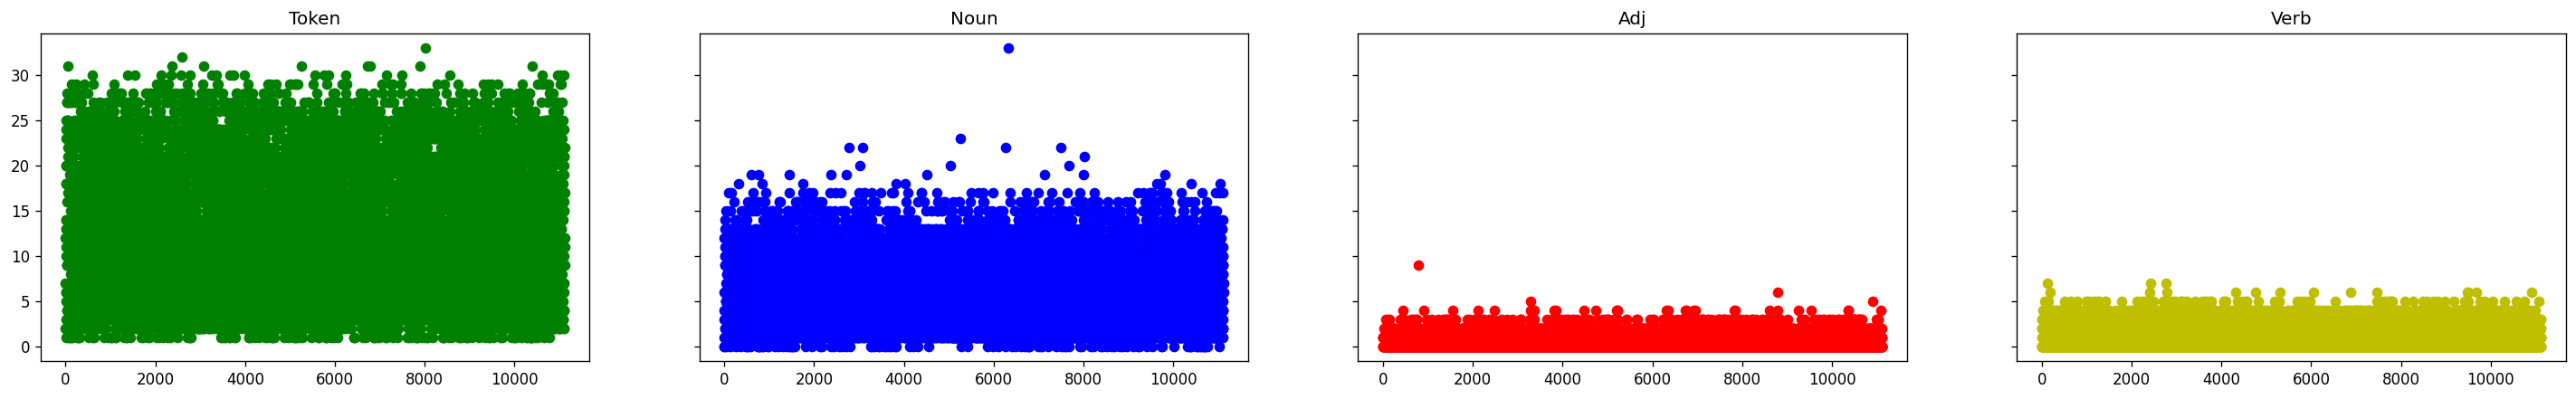

In [ ]:
#trực quan tần suất xuất hiện của từ đơn, danh từ, tính từ, động từ trong Neutral

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(30,4), sharey=True, dpi=120)

ax1.plot(static_neutral_tweet_df['token'], 'go')
ax2.plot(static_neutral_tweet_df['noun'], 'bo')
ax3.plot(static_neutral_tweet_df['adj'], 'ro')
ax4.plot(static_neutral_tweet_df['verb'], 'yo')

ax1.set_title('Token')
ax2.set_title('Noun')
ax3.set_title('Adj')
ax4.set_title('Verb')
plt.show()



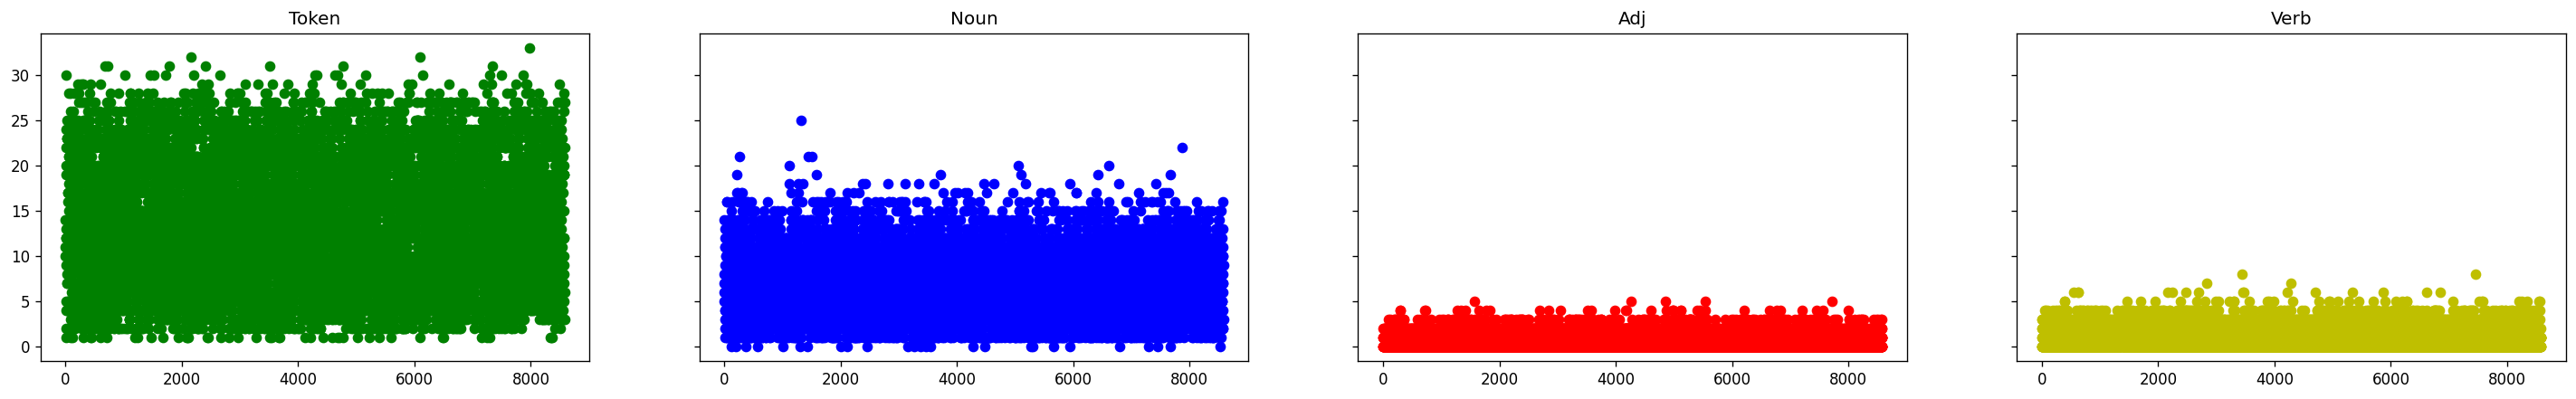

In [ ]:
#trực quan tần suất xuất hiện của từ đơn, danh từ, tính từ, động từ trong Negative

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(30,4), sharey=True, dpi=120)

ax1.plot(static_negative_tweet_df['token'], 'go')
ax2.plot(static_negative_tweet_df['noun'], 'bo')
ax3.plot(static_negative_tweet_df['adj'], 'ro')
ax4.plot(static_negative_tweet_df['verb'], 'yo')

ax1.set_title('Token')
ax2.set_title('Noun')
ax3.set_title('Adj')
ax4.set_title('Verb')
plt.show()



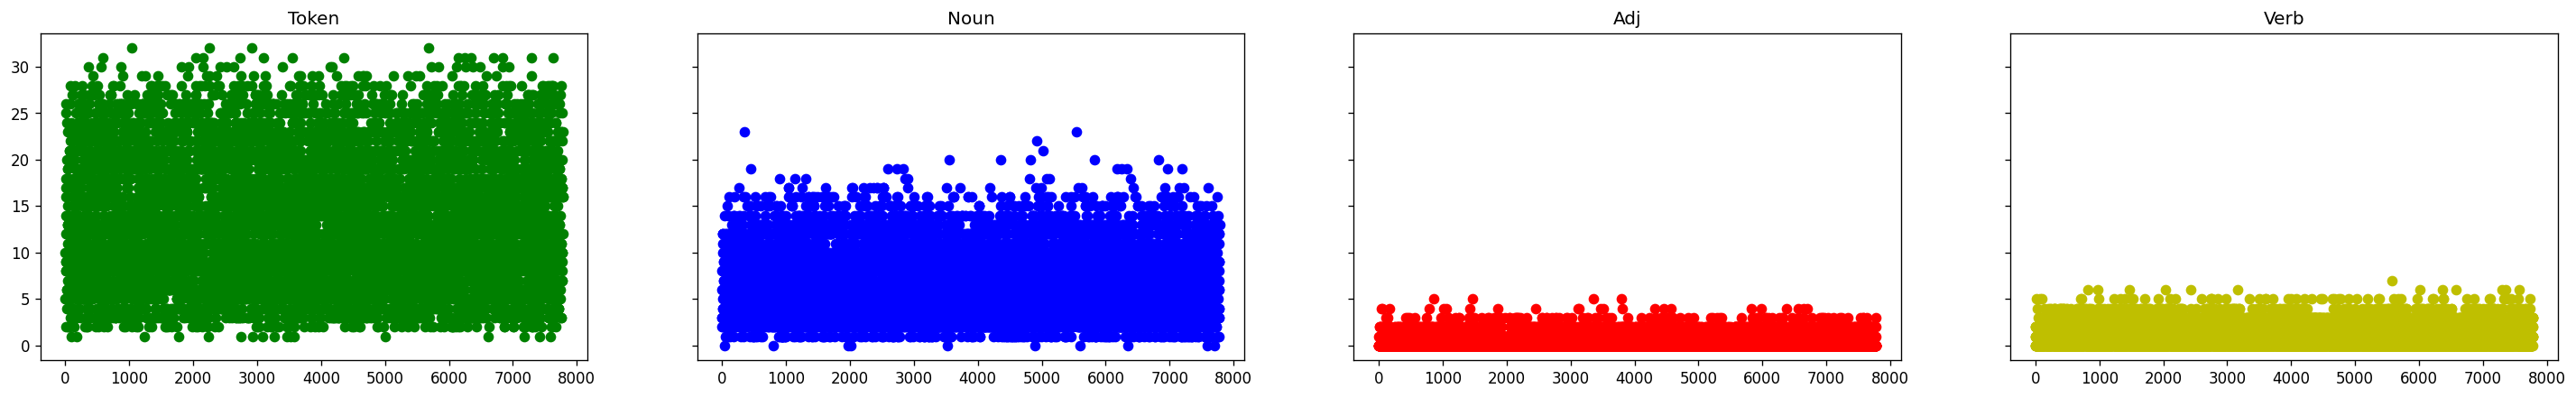

In [ ]:
#trực quan tần suất xuất hiện của từ đơn, danh từ, tính từ, động từ trong Positive

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(30,4), sharey=True, dpi=120)

ax1.plot(static_positive_tweet_df['token'], 'go')
ax2.plot(static_positive_tweet_df['noun'], 'bo')
ax3.plot(static_positive_tweet_df['adj'], 'ro')
ax4.plot(static_positive_tweet_df['verb'], 'yo')

ax1.set_title('Token')
ax2.set_title('Noun')
ax3.set_title('Adj')
ax4.set_title('Verb')
plt.show()



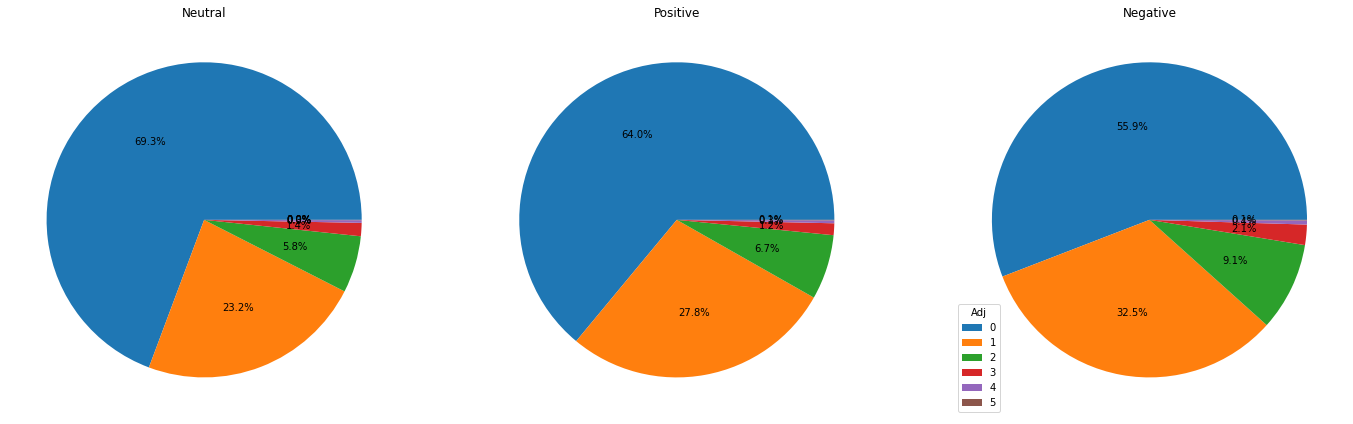

In [ ]:
#trực quan tần suất xuất hiện của tính từ

v1 = static_neutral_tweet_df['adj'].value_counts().sort_index()
v2 = static_positive_tweet_df['adj'].value_counts().sort_index()
v3 = static_negative_tweet_df['adj'].value_counts().sort_index()

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(24,30))
ax1.pie(v1, autopct="%.1f%%")
ax2.pie(v2, autopct="%.1f%%")
ax3.pie(v3, autopct="%.1f%%")

plt.legend(['0','1','2','3','4','5'], title = 'Adj')
ax1.set_title('Neutral')
ax2.set_title('Positive')
ax3.set_title('Negative')

plt.show()

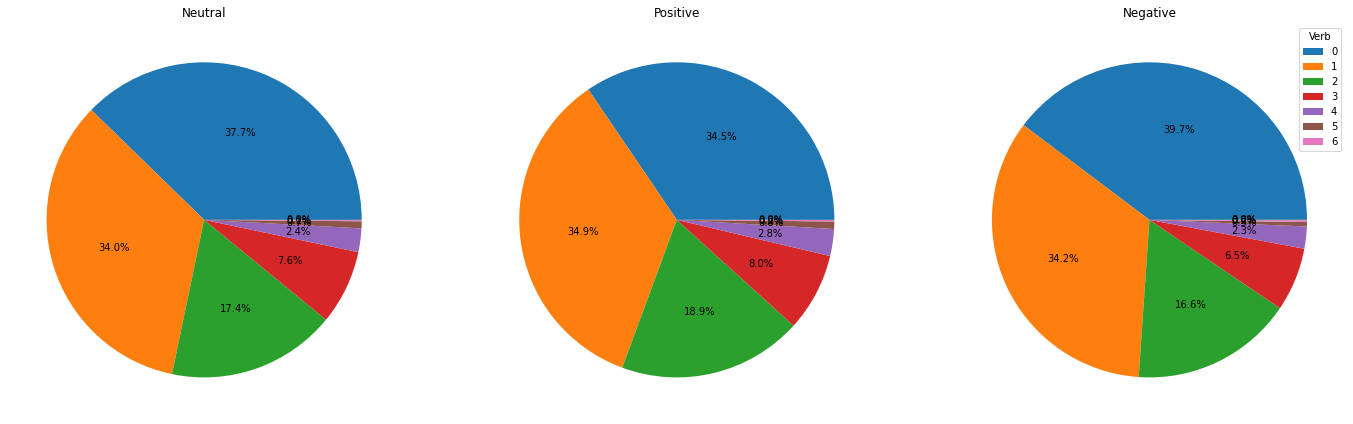

In [ ]:
#trực quan tần suất xuất hiện của động từ

v1 = static_neutral_tweet_df['verb'].value_counts().sort_index()
v2 = static_positive_tweet_df['verb'].value_counts().sort_index()
v3 = static_negative_tweet_df['verb'].value_counts().sort_index()

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(24,30))
ax1.pie(v1, autopct="%.1f%%")
ax2.pie(v2, autopct="%.1f%%")
ax3.pie(v3, autopct="%.1f%%")

plt.legend(['0','1','2','3','4','5','6'], title = 'Verb')
ax1.set_title('Neutral')
ax2.set_title('Positive')
ax3.set_title('Negative')

plt.show()